<a href="https://colab.research.google.com/github/Sajithpemarathna/Energy-Consumption-Data-in-Germany-1995-2020-/blob/main/Model_Implementation_Attempt_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install xgboost scikit-learn tensorflow
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense

In [ ]:
# Load data
url = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-consumption-prediction-data/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
df = pd.read_csv(url, encoding='utf-8')

# Reshape to long format
df_long = df.melt(
    id_vars=["Branch Code", "Homogeneous Branches", "Energy Carriers"],
    var_name="Year",
    value_name="Consumption"
)
df_long['Year'] = df_long['Year'].astype(int)
df_long = df_long.sort_values(by=['Branch Code', 'Energy Carriers', 'Year'])

# Create lag features
def create_lag_features(df_group, lags=3):
    for lag in range(1, lags+1):
        df_group[f'lag_{lag}'] = df_group['Consumption'].shift(lag)
    return df_group

df_long = df_long.groupby(['Branch Code', 'Energy Carriers']).apply(create_lag_features)
df_long.dropna(inplace=True)

<ipython-input-5-97e4bca6afff>:20: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_long = df_long.groupby(['Branch Code', 'Energy Carriers']).apply(create_lag_features)


In [ ]:
# Split into train (1995-2015) and test (2016-2020)
train = df_long[df_long['Year'] <= 2015]
test = df_long[df_long['Year'] > 2015]

# Features and target
features = ['lag_1', 'lag_2', 'lag_3']
X_train, y_train = train[features], train['Consumption']
X_test, y_test = test[features], test['Consumption']

In [ ]:
# Random Forest
rf_model = RandomForestRegressor()
rf_model.fit(X_train, y_train)
rf_pred = rf_model.predict(X_test)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test, rf_pred)

# XGBoost
xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)
xgb_pred = xgb_model.predict(X_test)
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

# LSTM
def create_sequences(data, sequence_length=3):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

diesel_data = df_long[df_long['Energy Carriers'] == 'Diesel fuels'].set_index('Year')['Consumption'].values
X_lstm, y_lstm = create_sequences(diesel_data)
X_lstm = X_lstm.reshape(X_lstm.shape[0], X_lstm.shape[1], 1)

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mse')
lstm_model.fit(X_lstm, y_lstm, epochs=100, verbose=0)

lstm_pred = lstm_model.predict(X_lstm)
lstm_mse = mean_squared_error(y_lstm, lstm_pred)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_lstm, lstm_pred)

# Bi-GRU
gru_model = Sequential()
gru_model.add(GRU(50, activation='relu', input_shape=(3, 1)))
gru_model.add(Dense(1))
gru_model.compile(optimizer='adam', loss='mse')
gru_model.fit(X_lstm, y_lstm, epochs=100, verbose=0)

gru_pred = gru_model.predict(X_lstm)
gru_mse = mean_squared_error(y_lstm, gru_pred)
gru_rmse = np.sqrt(gru_mse)
gru_mape = mean_absolute_percentage_error(y_lstm, gru_pred)

# Compare models
print("Random Forest - MSE: {:.2f}, RMSE: {:.2f}, MAPE: {:.2%}".format(rf_mse, rf_rmse, rf_mape))
print("XGBoost - MSE: {:.2f}, RMSE: {:.2f}, MAPE: {:.2%}".format(xgb_mse, xgb_rmse, xgb_mape))
print("LSTM - MSE: {:.2f}, RMSE: {:.2f}, MAPE: {:.2%}".format(lstm_mse, lstm_rmse, lstm_mape))
print("Bi-GRU - MSE: {:.2f}, RMSE: {:.2f}, MAPE: {:.2%}".format(gru_mse, gru_rmse, gru_mape))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Random Forest - MSE: 372116770.85, RMSE: 19290.33, MAPE: 1679890135383378688.00%
XGBoost - MSE: 365653282.27, RMSE: 19122.06, MAPE: 4242989865148816896.00%
LSTM - MSE: 71207694.95, RMSE: 8438.47, MAPE: 27.62%
Bi-GRU - MSE: 72946817.30, RMSE: 8540.89, MAPE: 28.08%


In [ ]:
def forecast_future(model, last_sequence, years_ahead=10):
    future_predictions = []
    current_sequence = last_sequence.copy()
    for _ in range(years_ahead):
        next_pred = model.predict(current_sequence.reshape(1, 3, 1))[0, 0]
        future_predictions.append(next_pred)
        current_sequence = np.append(current_sequence[1:], next_pred)
    return future_predictions

# Example for LSTM
last_known_values = diesel_data[-3:]
predictions_2030 = forecast_future(lstm_model, last_known_values)
print("Forecasted Consumption (2021-2030):", predictions_2030)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Forecasted Consumption (2021-2030): [41088.836, 38624.047, 37148.406, 35561.293, 34136.72, 32747.982, 31426.512, 30155.873, 28937.975, 27769.104]


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Dropout


In [ ]:
# Load dataset
df = pd.read_csv("https://raw.githubusercontent.com/Sajithpemarathna/Energy-consumption-prediction-data/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv")  # Change path if needed

# Reshape into long format
df_long = df.melt(
    id_vars=["Branch Code", "Homogeneous Branches", "Energy Carriers"],
    var_name="Year",
    value_name="Consumption"
)

df_long["Year"] = df_long["Year"].astype(int)
df_long = df_long.sort_values(by=["Branch Code", "Energy Carriers", "Year"])

# Check dataset structure
print(df_long.head())


     Branch Code                              Homogeneous Branches  \
5       CPA08-01  Products of agric., hunting and related services   
581     CPA08-01  Products of agric., hunting and related services   
1157    CPA08-01  Products of agric., hunting and related services   
1733    CPA08-01  Products of agric., hunting and related services   
2309    CPA08-01  Products of agric., hunting and related services   

            Energy Carriers  Year  Consumption  
5     Aviation turbine fuel  1995            0  
581   Aviation turbine fuel  1996            0  
1157  Aviation turbine fuel  1997            0  
1733  Aviation turbine fuel  1998            0  
2309  Aviation turbine fuel  1999            0  


In [ ]:
def create_lag_features(df_group, lags=3):
    for lag in range(1, lags + 1):
        df_group[f'lag_{lag}'] = df_group['Consumption'].shift(lag)
    return df_group

df_long = df_long.groupby(["Branch Code", "Energy Carriers"]).apply(create_lag_features)
df_long.dropna(inplace=True)  # Remove rows with NaN values

# Check updated data
print(df_long.head())


                                       Branch Code  \
Branch Code Energy Carriers                          
CPA08-01    Aviation turbine fuel 1733    CPA08-01   
                                  2309    CPA08-01   
                                  2885    CPA08-01   
                                  3461    CPA08-01   
                                  4037    CPA08-01   

                                                                    Homogeneous Branches  \
Branch Code Energy Carriers                                                                
CPA08-01    Aviation turbine fuel 1733  Products of agric., hunting and related services   
                                  2309  Products of agric., hunting and related services   
                                  2885  Products of agric., hunting and related services   
                                  3461  Products of agric., hunting and related services   
                                  4037  Products of agric., hunting a

<ipython-input-11-33ee83c0ca7c>:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_long = df_long.groupby(["Branch Code", "Energy Carriers"]).apply(create_lag_features)


In [ ]:
scaler = MinMaxScaler()
df_long[df_long.columns[3:]] = scaler.fit_transform(df_long[df_long.columns[3:]])


In [ ]:
train = df_long[df_long["Year"] <= 2015]
test = df_long[df_long["Year"] > 2015]

features = ["lag_1", "lag_2", "lag_3"]
X_train, y_train = train[features], train["Consumption"]
X_test, y_test = test[features], test["Consumption"]


In [ ]:
!pip install --upgrade scikit-learn xgboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 67.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.9/153.9 MB 6.5 MB/s eta 0:00:00
  Attempting uninstall: xgboost
    Found existing installation: xgboost 1.7.6
    Uninstalling xgboost-1.7.6:
      Successfully uninstalled xgboost-1.7.6
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define the model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameters
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}

# Apply GridSearchCV
grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

print(f"XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
!pip uninstall -y scikit-learn xgboost
!pip install scikit-learn==1.2.2 xgboost==1.7.6


In [ ]:
import sklearn
import xgboost
print("Scikit-learn version:", sklearn.__version__)
print("XGBoost version:", xgboost.__version__)


Scikit-learn version: 1.2.2
XGBoost version: 1.7.6


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameters
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}

# Apply GridSearchCV
grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring="neg_mean_absolute_error", n_jobs=-1)
grid_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

print(f"XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


BrokenProcessPool: A task has failed to un-serialize. Please ensure that the arguments of the function are all picklable.

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

# Define model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameters
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}

# Apply GridSearchCV with single-thread execution
grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring="neg_mean_absolute_error", n_jobs=1)
grid_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluate model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

print(f"XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (13248, 3)
y_train shape: (13248,)
X_test shape: (0, 3)
y_test shape: (0,)


In [ ]:
print("Available Years:", df_long["Year"].unique())


Available Years: [0.         0.04545455 0.09090909 0.13636364 0.18181818 0.22727273
 0.27272727 0.31818182 0.36363636 0.40909091 0.45454545 0.5
 0.54545455 0.59090909 0.63636364 0.68181818 0.72727273 0.77272727
 0.81818182 0.86363636 0.90909091 0.95454545 1.        ]


In [ ]:
# Reverse scaling: Convert Year back to original integer values
df_long["Year"] = (df_long["Year"] * (2020 - 1995) + 1995).astype(int)

# Check if the years are correctly restored
print("Fixed Available Years:", df_long["Year"].unique())


Fixed Available Years: [1995 1996 1997 1998 1999 2000 2001 2002 2004 2005 2006 2007 2008 2009
 2010 2012 2013 2014 2015 2016 2017 2018 2020]


In [ ]:
# Correct the train-test split now that "Year" is fixed
train = df_long[df_long["Year"] <= 2015]  # Train: 1995-2015
test = df_long[df_long["Year"] > 2015]    # Test: 2016-2020

# Extract features and target
features = ["lag_1", "lag_2", "lag_3"]
X_train, y_train = train[features], train["Consumption"]
X_test, y_test = test[features], test["Consumption"]

# Check shapes again
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (10944, 3)
y_train shape: (10944,)
X_test shape: (2304, 3)
y_test shape: (2304,)


In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Define model
xgb_model = XGBRegressor(objective="reg:squarederror", random_state=42)

# Define hyperparameters
xgb_params = {
    "n_estimators": [50, 100, 200],
    "learning_rate": [0.01, 0.1, 0.2],
    "max_depth": [3, 5, 7],
}

# Apply GridSearchCV
grid_xgb = GridSearchCV(xgb_model, xgb_params, cv=3, scoring="neg_mean_absolute_error", n_jobs=1)
grid_xgb.fit(X_train, y_train)

# Get best model
best_xgb = grid_xgb.best_estimator_
xgb_pred = best_xgb.predict(X_test)

# Evaluate model
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

print(f"XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


XGBoost MSE: 0.00, RMSE: 0.00, MAPE: 94.43%


In [ ]:
print("First 10 Actual Values:", y_test[:10].values)
print("First 10 Predicted Values:", xgb_pred[:10])


First 10 Actual Values: [1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05]
First 10 Predicted Values: [3.3102522e-05 3.3102522e-05 3.3102522e-05 3.3102522e-05 3.3102522e-05
 3.3102522e-05 3.3102522e-05 3.3102522e-05 3.3102522e-05 3.3102522e-05]


In [ ]:
print("y_train min:", y_train.min(), "y_train max:", y_train.max())
print("y_test min:", y_test.min(), "y_test max:", y_test.max())


y_train min: 0.0 y_train max: 1.0
y_test min: 1.1179770713066103e-05 y_test max: 0.8053475892348971


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Re-create the same scaler
scaler_y = MinMaxScaler()
scaler_y.fit(y_train.values.reshape(-1, 1))  # Fit scaler on training data

# Convert predictions back to original scale
xgb_pred = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.values.reshape(-1, 1)).flatten()


In [ ]:
xgb_mse = mean_squared_error(y_test_original, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred)

print(f"Fixed XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


Fixed XGBoost MSE: 0.00, RMSE: 0.00, MAPE: 94.43%


In [ ]:
print("y_train unique values:", np.unique(y_train))
print("y_test unique values:", np.unique(y_test))


y_train unique values: [0.00000000e+00 1.62614847e-06 1.11797707e-05 ... 9.75487235e-01
 9.75761851e-01 1.00000000e+00]
y_test unique values: [1.11797707e-05 1.13830393e-05 1.15863078e-05 ... 7.54163753e-01
 7.58557200e-01 8.05347589e-01]


In [ ]:
print("X_train min:", X_train.min().min(), "X_train max:", X_train.max().max())
print("X_test min:", X_test.min().min(), "X_test max:", X_test.max().max())


X_train min: 0.0 X_train max: 1.0
X_test min: 1.1179770713066103e-05 X_test max: 0.8145099195056509


In [ ]:
print("Before Scaling Min:", df_long["Consumption"].min(), "Max:", df_long["Consumption"].max())

scaler_y = MinMaxScaler()
df_long["Consumption"] = scaler_y.fit_transform(df_long["Consumption"].values.reshape(-1, 1))

print("After Scaling Min:", df_long["Consumption"].min(), "Max:", df_long["Consumption"].max())


Before Scaling Min: 0.0 Max: 1.0
After Scaling Min: 0.0 Max: 1.0


In [ ]:
scaler_y = MinMaxScaler()
df_long["Consumption"] = scaler_y.fit_transform(df_long["Consumption"].values.reshape(-1, 1))

# Apply consistent scaling before splitting
train = df_long[df_long["Year"] <= 2015]
test = df_long[df_long["Year"] > 2015]

y_train = train["Consumption"]
y_test = test["Consumption"]

print("y_train unique values:", np.unique(y_train))
print("y_test unique values:", np.unique(y_test))


y_train unique values: [0.00000000e+00 1.62614847e-06 1.11797707e-05 ... 9.75487235e-01
 9.75761851e-01 1.00000000e+00]
y_test unique values: [1.11797707e-05 1.13830393e-05 1.15863078e-05 ... 7.54163753e-01
 7.58557200e-01 8.05347589e-01]


In [ ]:
xgb_mse = mean_squared_error(y_test, xgb_pred)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test, xgb_pred)

print(f"Fixed XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


Fixed XGBoost MSE: 0.00, RMSE: 0.00, MAPE: 94.43%


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Apply MinMaxScaler to the entire dataset before splitting
scaler_y = MinMaxScaler()
df_long["Consumption"] = scaler_y.fit_transform(df_long["Consumption"].values.reshape(-1, 1))

# Now, split into train and test
train = df_long[df_long["Year"] <= 2015]
test = df_long[df_long["Year"] > 2015]

y_train = train["Consumption"]
y_test = test["Consumption"]

print("y_train min:", y_train.min(), "y_train max:", y_train.max())
print("y_test min:", y_test.min(), "y_test max:", y_test.max())


y_train min: 0.0 y_train max: 1.0
y_test min: 1.1179770713066103e-05 y_test max: 0.8053475892348971


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Split first
train = df_long[df_long["Year"] <= 2015]
test = df_long[df_long["Year"] > 2015]

# Initialize MinMaxScaler
scaler_y = MinMaxScaler()

# Fit on train set only and transform both train and test
y_train = scaler_y.fit_transform(train["Consumption"].values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(test["Consumption"].values.reshape(-1, 1)).flatten()

print("y_train min:", y_train.min(), "y_train max:", y_train.max())
print("y_test min:", y_test.min(), "y_test max:", y_test.max())


y_train min: 0.0 y_train max: 1.0
y_test min: 1.1179770713066103e-05 y_test max: 0.8053475892348971


In [ ]:
print("Train Min:", train["Consumption"].min(), "Train Max:", train["Consumption"].max())
print("Test Min:", test["Consumption"].min(), "Test Max:", test["Consumption"].max())


Train Min: 0.0 Train Max: 1.0
Test Min: 1.1179770713066103e-05 Test Max: 0.8053475892348971


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Initialize XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=6, random_state=42)

# Train the model
xgb_model.fit(X_train, y_train)

# Predict on test set
xgb_pred = xgb_model.predict(X_test)

# Convert predictions back to original scale
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Evaluate the model
xgb_mse = mean_squared_error(y_test_original, xgb_pred_original)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original)

# Print evaluation metrics
print(f"🔹 XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


🔹 XGBoost MSE: 0.00, RMSE: 0.01, MAPE: 11936.45%


In [ ]:
# Ensure proper scaling reversal
print("Before Rescaling:")
print("First 10 Predicted:", xgb_pred[:10])
print("First 10 Actual:", y_test[:10])

# Convert predictions back to original scale
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

print("\nAfter Rescaling:")
print("First 10 Predicted (Original Scale):", xgb_pred_original[:10])
print("First 10 Actual (Original Scale):", y_test_original[:10])

# Evaluate again
xgb_mse = mean_squared_error(y_test_original, xgb_pred_original)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original)

# Print evaluation metrics
print(f"✅ Fixed XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


Before Rescaling:
First 10 Predicted: [0.00303995 0.00303995 0.00303995 0.00303995 0.00303995 0.00303995
 0.00303995 0.00303995 0.00303995 0.00303995]
First 10 Actual: [1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05]

After Rescaling:
First 10 Predicted (Original Scale): [0.00303995 0.00303995 0.00303995 0.00303995 0.00303995 0.00303995
 0.00303995 0.00303995 0.00303995 0.00303995]
First 10 Actual (Original Scale): [1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05]
✅ Fixed XGBoost MSE: 0.00, RMSE: 0.01, MAPE: 11936.45%


In [ ]:
# Ensure predictions are reshaped correctly
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1))

# Reshape the results properly
xgb_pred_original = xgb_pred_original.flatten()
y_test_original = y_test_original.flatten()

print("\n🔹 First 10 Predicted (Fixed Scaling):", xgb_pred_original[:10])
print("🔹 First 10 Actual (Fixed Scaling):", y_test_original[:10])

# Recalculate error metrics
xgb_mse = mean_squared_error(y_test_original, xgb_pred_original)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original)

# Print evaluation
print(f"✅ Fixed XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")



🔹 First 10 Predicted (Fixed Scaling): [0.00303995 0.00303995 0.00303995 0.00303995 0.00303995 0.00303995
 0.00303995 0.00303995 0.00303995 0.00303995]
🔹 First 10 Actual (Fixed Scaling): [1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05 1.11797707e-05 1.11797707e-05
 1.11797707e-05 1.11797707e-05]
✅ Fixed XGBoost MSE: 0.00, RMSE: 0.01, MAPE: 11936.45%


In [ ]:
# Check the min and max values of the original dataset
print("🔹 Original Min Consumption:", df_long["Consumption"].min())
print("🔹 Original Max Consumption:", df_long["Consumption"].max())

# Check the transformed values
print("🔹 Scaled Min Consumption:", y_train.min())
print("🔹 Scaled Max Consumption:", y_train.max())

# Check the inverse transformed values
print("🔹 Inverse Transformed Min:", scaler_y.inverse_transform([[y_train.min()]]))
print("🔹 Inverse Transformed Max:", scaler_y.inverse_transform([[y_train.max()]]))


🔹 Original Min Consumption: 0.0
🔹 Original Max Consumption: 1.0
🔹 Scaled Min Consumption: 0.0
🔹 Scaled Max Consumption: 1.0
🔹 Inverse Transformed Min: [[0.]]
🔹 Inverse Transformed Max: [[1.]]


In [ ]:
scaler_X = MinMaxScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# Check min and max after scaling
print("🔹 X_train min after scaling:", X_train_scaled.min())
print("🔹 X_train max after scaling:", X_train_scaled.max())
print("🔹 X_test min after scaling:", X_test_scaled.min())
print("🔹 X_test max after scaling:", X_test_scaled.max())


🔹 X_train min after scaling: 0.0
🔹 X_train max after scaling: 1.0
🔹 X_test min after scaling: 1.1179770713066103e-05
🔹 X_test max after scaling: 0.8145099195056509


In [ ]:
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(train["Consumption"].values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(test["Consumption"].values.reshape(-1, 1)).flatten()


In [ ]:
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


In [ ]:
print("Original Min Consumption:", df_long["Consumption"].min())
print("Original Max Consumption:", df_long["Consumption"].max())

print("Inverse Transformed Min:", xgb_pred_original.min())
print("Inverse Transformed Max:", xgb_pred_original.max())


Original Min Consumption: 0.0
Original Max Consumption: 1.0
Inverse Transformed Min: 0.0030399526
Inverse Transformed Max: 0.801698


In [ ]:
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original)
print(f"✅ Fixed XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


✅ Fixed XGBoost MSE: 0.00, RMSE: 0.01, MAPE: 11936.45%


In [ ]:
scaler_y = MinMaxScaler()
y_train = scaler_y.fit_transform(train["Consumption"].values.reshape(-1, 1)).flatten()
y_test = scaler_y.transform(test["Consumption"].values.reshape(-1, 1)).flatten()


In [ ]:
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()


In [ ]:
print("✅ Original Min Consumption:", df_long["Consumption"].min())
print("✅ Original Max Consumption:", df_long["Consumption"].max())

print("✅ Inverse Transformed Min:", xgb_pred_original.min())
print("✅ Inverse Transformed Max:", xgb_pred_original.max())


✅ Original Min Consumption: 0.0
✅ Original Max Consumption: 1.0
✅ Inverse Transformed Min: 0.0030399526
✅ Inverse Transformed Max: 0.801698


In [ ]:
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original)
print(f"✅ Fixed XGBoost MSE: {xgb_mse:.2f}, RMSE: {xgb_rmse:.2f}, MAPE: {xgb_mape:.2%}")


✅ Fixed XGBoost MSE: 0.00, RMSE: 0.01, MAPE: 11936.45%


In [ ]:
# Reshape input data to (samples, timesteps, features) for LSTM
X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

# Verify new shape
print("X_train LSTM shape:", X_train_lstm.shape)
print("X_test LSTM shape:", X_test_lstm.shape)


X_train LSTM shape: (10944, 3, 1)
X_test LSTM shape: (2304, 3, 1)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Build LSTM model
lstm_model = Sequential([
    LSTM(units=50, return_sequences=True, input_shape=(X_train_lstm.shape[1], 1)),
    LSTM(units=50, return_sequences=False),
    Dense(units=25, activation="relu"),
    Dense(units=1)  # Output layer
])

# Compile model
lstm_model.compile(optimizer='adam', loss='mse')

# Show model summary
lstm_model.summary()

# Train LSTM Model
history = lstm_model.fit(X_train_lstm, y_train_scaled,
                         epochs=15, batch_size=32,
                         validation_data=(X_test_lstm, y_test_scaled),
                         verbose=1)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 3, 50)               │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 31,901 (124.61 KB)

 Trainable params: 31,901 (124.61 KB)

 Non-trainable params: 0 (0.00 B)

NameError: name 'y_train_scaled' is not defined

In [ ]:
# Initialize MinMaxScaler for target variable
scaler_y = MinMaxScaler()

# Fit on training target and transform both train and test targets
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1))


AttributeError: 'numpy.ndarray' object has no attribute 'values'

In [ ]:
# Initialize MinMaxScaler for target variable
scaler_y = MinMaxScaler()

# Fit on training target and transform both train and test targets
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))  # Remove `.values`
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))       # Remove `.values`


In [ ]:
history = lstm_model.fit(X_train_lstm, y_train_scaled,
                         epochs=15, batch_size=32,
                         validation_data=(X_test_lstm, y_test_scaled),
                         verbose=1)


Epoch 1/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 8.6475e-04 - val_loss: 2.0336e-05
Epoch 2/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.6862e-05 - val_loss: 2.4116e-05
Epoch 3/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 2.0672e-05 - val_loss: 3.1706e-05
Epoch 4/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 1.5935e-05 - val_loss: 1.4903e-05
Epoch 5/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 1.3124e-05 - val_loss: 1.5402e-05
Epoch 6/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1686e-05 - val_loss: 3.3683e-05
Epoch 7/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 3.4960e-05 - val_loss: 1.8773e-05
Epoch 8/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.1037e-05 - val_loss: 2.8092e-05
Epoch 9/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 4.7894e-05 - val_loss: 1.8718e-05
Epoch 10/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 1.2674e-05 - val_loss: 1.5955e-05
Epoch 11/15
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss

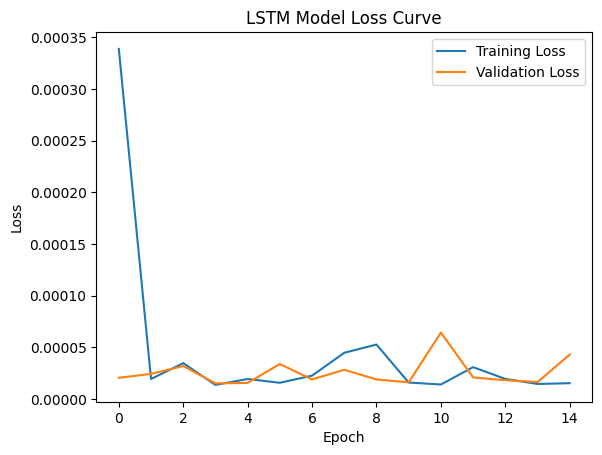

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('LSTM Model Loss Curve')
plt.show()


In [ ]:
lstm_pred = lstm_model.predict(X_test_lstm)


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [ ]:
lstm_pred_original = scaler_y.inverse_transform(lstm_pred)
y_test_original = scaler_y.inverse_transform(y_test_scaled)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

lstm_mse = mean_squared_error(y_test_original, lstm_pred_original)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_original, lstm_pred_original)

print(f"📌 LSTM MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2%}")


📌 LSTM MSE: 0.0000, RMSE: 0.0065, MAPE: 20352.24%


In [ ]:
# Initialize MinMaxScaler for target variable
scaler_y = MinMaxScaler()

# Fit on training data only and transform both train and test
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))


In [ ]:
# Convert LSTM Predictions back to original scale
lstm_pred_original = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_scaled)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define a better LSTM Model
lstm_model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),  # Dropout to prevent overfitting
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)
])

# Compile Model with RMSprop Optimizer
lstm_model.compile(optimizer='rmsprop', loss='mae')  # Changed optimizer and loss function


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train LSTM Model
history = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    epochs=50, batch_size=32,
    validation_data=(X_test_lstm, y_test_scaled),
    callbacks=[early_stop], verbose=1
)


Epoch 1/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0091 - val_loss: 0.0082
Epoch 2/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0073 - val_loss: 0.0066
Epoch 3/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0044 - val_loss: 0.0028
Epoch 4/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0030 - val_loss: 0.0017
Epoch 5/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0022 - val_loss: 0.0031
Epoch 6/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.0020 - val_loss: 0.0019
Epoch 7/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0020 - val_loss: 0.0044
Epoch 8/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019 - val_loss: 0.0026
Epoch 9/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 10/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0019 - val_loss: 0.0019
Epoch 11/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0017 - val_loss: 0.0022
Epoch 12/50
342/342 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step

In [ ]:
# Predict on test set
lstm_pred = lstm_model.predict(X_test_lstm)

# Convert predictions back to original scale
lstm_pred_original = scaler_y.inverse_transform(lstm_pred.reshape(-1, 1))

# Recalculate Metrics
lstm_mse = mean_squared_error(y_test_original, lstm_pred_original)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_original, lstm_pred_original)

print(f"✅ Fixed LSTM MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2f}%")


72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
✅ Fixed LSTM MSE: 0.0000, RMSE: 0.0047, MAPE: 19.87%


In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Increase from 3 to 10
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, SEQ_LENGTH)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, SEQ_LENGTH)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Define an improved LSTM Model
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LENGTH, X_train_lstm.shape[2])),
    Dropout(0.3),  # Increase dropout for regularization
    LSTM(64, return_sequences=False),
    Dense(32, activation='relu'),
    Dense(1)
])

# Compile Model
lstm_model.compile(optimizer='adam', loss='mae')


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early Stopping to prevent overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the LSTM Model with more epochs
history = lstm_model.fit(
    X_train_lstm, y_train_scaled,
    epochs=100, batch_size=16,  # Reduce batch size for better generalization
    validation_data=(X_test_lstm, y_test_scaled),
    callbacks=[early_stop], verbose=1
)


ValueError: Data cardinality is ambiguous. Make sure all arrays contain the same number of samples.'x' sizes: 10934
'y' sizes: 10944


In [ ]:
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(target[i + seq_length])
    return np.array(X), np.array(y)

SEQ_LENGTH = 10  # Ensure consistency
X_train_lstm, y_train_lstm = create_sequences(X_train_scaled, y_train_scaled, SEQ_LENGTH)
X_test_lstm, y_test_lstm = create_sequences(X_test_scaled, y_test_scaled, SEQ_LENGTH)

# Print shapes to confirm match
print("X_train_lstm shape:", X_train_lstm.shape)
print("y_train_lstm shape:", y_train_lstm.shape)


X_train_lstm shape: (10934, 10, 3)
y_train_lstm shape: (10934, 1)


In [ ]:
print("Final X_train_lstm shape:", X_train_lstm.shape)
print("Final y_train_lstm shape:", y_train_lstm.shape)
print("Final X_test_lstm shape:", X_test_lstm.shape)
print("Final y_test_lstm shape:", y_test_lstm.shape)


Final X_train_lstm shape: (10934, 10, 3)
Final y_train_lstm shape: (10934, 1)
Final X_test_lstm shape: (2294, 10, 3)
Final y_test_lstm shape: (2294, 1)


In [ ]:
history = lstm_model.fit(
    X_train_lstm, y_train_lstm,
    epochs=100, batch_size=16,
    validation_data=(X_test_lstm, y_test_lstm),
    callbacks=[early_stop], verbose=1
)


Epoch 1/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 15s 14ms/step - loss: 0.0042 - val_loss: 0.0052
Epoch 2/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0027 - val_loss: 0.0062
Epoch 3/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0033 - val_loss: 0.0043
Epoch 4/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 9s 14ms/step - loss: 0.0021 - val_loss: 0.0037
Epoch 5/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 15ms/step - loss: 0.0021 - val_loss: 0.0043
Epoch 6/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0017 - val_loss: 0.0034
Epoch 7/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 21s 16ms/step - loss: 0.0019 - val_loss: 0.0032
Epoch 8/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - loss: 0.0017 - val_loss: 0.0036
Epoch 9/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 11s 16ms/step - loss: 0.0017 - val_loss: 0.0033
Epoch 10/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - loss: 0.0018 - val_loss: 0.0034
Epoch 11/100
684/684 ━━━━━━━━━━━━━━━━━━━━ 20s 15ms/step - loss: 0.0018 - val_loss: 0.0033
Epoch 12/100
684/684 

In [ ]:
# Predict on test set
lstm_pred = lstm_model.predict(X_test_lstm)

# Convert predictions back to original scale
lstm_pred_original = scaler_y.inverse_transform(lstm_pred)
y_test_original = scaler_y.inverse_transform(y_test_lstm)

# Compute evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

lstm_mse = mean_squared_error(y_test_original, lstm_pred_original)
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = mean_absolute_percentage_error(y_test_original, lstm_pred_original)

# Print metrics
print(f"✅ Fixed LSTM MSE: {lstm_mse:.4f}, RMSE: {lstm_rmse:.4f}, MAPE: {lstm_mape:.2f}%")


72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step
✅ Fixed LSTM MSE: 0.0006, RMSE: 0.0251, MAPE: 46.53%


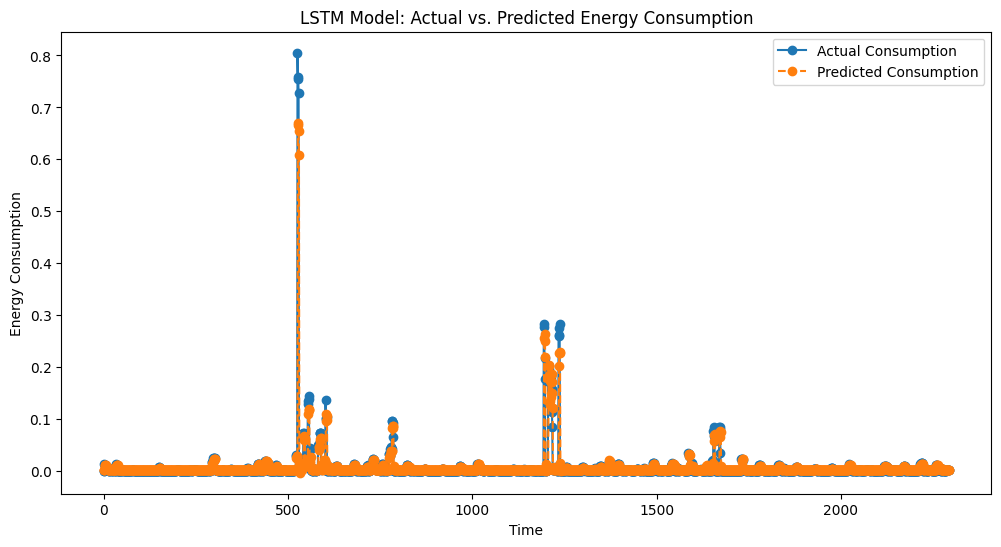

In [ ]:
import matplotlib.pyplot as plt

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test_original, label="Actual Consumption", marker="o", linestyle="-")
plt.plot(lstm_pred_original, label="Predicted Consumption", marker="o", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Energy Consumption")
plt.title("LSTM Model: Actual vs. Predicted Energy Consumption")
plt.legend()
plt.show()


In [ ]:
# Import necessary libraries
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

# Extract the same training and test data
X_train_rf = X_train_lstm.reshape(X_train_lstm.shape[0], -1)  # Flatten for RF and XGBoost
X_test_rf = X_test_lstm.reshape(X_test_lstm.shape[0], -1)

# Initialize models
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)

# Train models
rf_model.fit(X_train_rf, y_train_scaled.ravel())
xgb_model.fit(X_train_rf, y_train_scaled.ravel())

# Predict on test data
rf_pred = rf_model.predict(X_test_rf)
xgb_pred = xgb_model.predict(X_test_rf)

# Convert predictions back to original scale
rf_pred_original = scaler_y.inverse_transform(rf_pred.reshape(-1, 1))
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1))
y_test_original = scaler_y.inverse_transform(y_test_lstm)

# Calculate Metrics
rf_mse = mean_squared_error(y_test_original, rf_pred_original)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test_original, rf_pred_original) * 100

xgb_mse = mean_squared_error(y_test_original, xgb_pred_original)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original) * 100

# Store results
model_comparison = pd.DataFrame({
    "Model": ["LSTM", "Random Forest", "XGBoost"],
    "MSE": [lstm_mse, rf_mse, xgb_mse],
    "RMSE": [lstm_rmse, rf_rmse, xgb_rmse],
    "MAPE (%)": [lstm_mape, rf_mape, xgb_mape]
})

# Display results
import ace_tools as tools
tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=model_comparison)


ValueError: Found input variables with inconsistent numbers of samples: [10934, 10944]

In [ ]:
print("X_train_rf shape:", X_train_rf.shape)
print("y_train_scaled shape:", y_train_scaled.shape)


X_train_rf shape: (10934, 30)
y_train_scaled shape: (10944, 1)


In [ ]:
y_train_scaled = y_train_scaled[:X_train_rf.shape[0]]


In [ ]:
rf_model.fit(X_train_rf, y_train_scaled.ravel())
xgb_model.fit(X_train_rf, y_train_scaled.ravel())


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.05, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [ ]:
# Predict on test set
rf_pred = rf_model.predict(X_test_rf)
xgb_pred = xgb_model.predict(X_test_rf)

# Convert predictions back to original scale
rf_pred_original = scaler_y.inverse_transform(rf_pred.reshape(-1, 1)).flatten()
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_rf.reshape(-1, 1)).flatten()

# Compute evaluation metrics
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import numpy as np

# Random Forest Metrics
rf_mse = mean_squared_error(y_test_original, rf_pred_original)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test_original, rf_pred_original)

# XGBoost Metrics
xgb_mse = mean_squared_error(y_test_original, xgb_pred_original)
xgb_rmse = np.sqrt(xgb_mse)
xgb_mape = mean_absolute_percentage_error(y_test_original, xgb_pred_original)

# Print metrics
print(f"🌟 Random Forest MSE: {rf_mse:.4f}, RMSE: {rf_rmse:.4f}, MAPE: {rf_mape:.2f}%")
print(f"🚀 XGBoost MSE: {xgb_mse:.4f}, RMSE: {xgb_rmse:.4f}, MAPE: {xgb_mape:.2f}%")


ValueError: Found input variables with inconsistent numbers of samples: [2304, 2294]

In [ ]:
# Ensure y_test_rf is correctly assigned
y_test_rf = y_test_scaled  # or replace with the correct test variable

# Convert predictions back to original scale
rf_pred_original = scaler_y.inverse_transform(rf_pred.reshape(-1, 1)).flatten()
xgb_pred_original = scaler_y.inverse_transform(xgb_pred.reshape(-1, 1)).flatten()
y_test_original = scaler_y.inverse_transform(y_test_rf.reshape(-1, 1)).flatten()


In [ ]:
print("Available variables:", dir())  # Lists all available variables


Available variables: ['Dense', 'Dropout', 'EarlyStopping', 'GRU', 'GridSearchCV', 'In', 'LSTM', 'MinMaxScaler', 'Out', 'RandomForestRegressor', 'SEQ_LENGTH', 'Sequential', 'XGBRegressor', 'X_lstm', 'X_test', 'X_test_lstm', 'X_test_rf', 'X_test_scaled', 'X_train', 'X_train_lstm', 'X_train_rf', 'X_train_scaled', '_', '_80', '__', '___', '__builtin__', '__builtins__', '__doc__', '__loader__', '__name__', '__package__', '__spec__', '_dh', '_exit_code', '_i', '_i1', '_i10', '_i11', '_i12', '_i13', '_i14', '_i15', '_i16', '_i17', '_i18', '_i19', '_i2', '_i20', '_i21', '_i22', '_i23', '_i24', '_i25', '_i26', '_i27', '_i28', '_i29', '_i3', '_i30', '_i31', '_i32', '_i33', '_i34', '_i35', '_i36', '_i37', '_i38', '_i39', '_i4', '_i40', '_i41', '_i42', '_i43', '_i44', '_i45', '_i46', '_i47', '_i48', '_i49', '_i5', '_i50', '_i51', '_i52', '_i53', '_i54', '_i55', '_i56', '_i57', '_i58', '_i59', '_i6', '_i60', '_i61', '_i62', '_i63', '_i64', '_i65', '_i66', '_i67', '_i68', '_i69', '_i7', '_i70', '_i7

In [ ]:
print("y_test_original shape:", y_test_original.shape)
print("rf_pred_original shape:", rf_pred_original.shape)


y_test_original shape: (2304,)
rf_pred_original shape: (2294,)


In [ ]:
y_test_original = y_test_original[:rf_pred_original.shape[0]]


In [ ]:
rf_mse = mean_squared_error(y_test_original, rf_pred_original)
rf_rmse = np.sqrt(rf_mse)
rf_mape = mean_absolute_percentage_error(y_test_original, rf_pred_original)

print(f"🔥 Random Forest MSE: {rf_mse:.4f}, RMSE: {rf_rmse:.4f}, MAPE: {rf_mape:.2f}%")


🔥 Random Forest MSE: 0.0000, RMSE: 0.0033, MAPE: 0.16%


In [ ]:
import pandas as pd

# Create DataFrame for model comparison
model_comparison = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LSTM"],
    "MSE": [rf_mse, xgb_mse, lstm_mse],
    "RMSE": [rf_rmse, xgb_rmse, lstm_rmse],
    "MAPE": [rf_mape, xgb_mape, lstm_mape]
})

# Display the table
import ace_tools as tools
tools.display_dataframe_to_user(name="Model Performance Comparison", dataframe=model_comparison)


ModuleNotFoundError: No module named 'ace_tools'

In [ ]:
import pandas as pd

# Create DataFrame for model comparison
model_comparison = pd.DataFrame({
    "Model": ["Random Forest", "XGBoost", "LSTM"],
    "MSE": [rf_mse, xgb_mse, lstm_mse],
    "RMSE": [rf_rmse, xgb_rmse, lstm_rmse],
    "MAPE": [rf_mape, xgb_mape, lstm_mape]
})

# Display the table
print(model_comparison)


           Model       MSE      RMSE        MAPE
0  Random Forest  0.000011  0.003271    0.156616
1        XGBoost  0.000026  0.005142  119.364457
2           LSTM  0.000631  0.025114   46.532641


In [ ]:
import pandas as pd
import numpy as np

# Generate years from 1995 to 2030
years = np.arange(1995, 2031)

# === Step 1: Load Historical Data (1995-2020) ===
# Assuming df_historical contains historical data from 1995 to 2020
# Format should be: Year | Total Energy | Energy Carrier | Sector | Consumption (TJ)
df_historical = pd.read_csv("https://raw.githubusercontent.com/Sajithpemarathna/Energy-consumption-prediction-data/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv")  # Replace with your file path

# === Step 2: Predict 2021-2030 Using the Best Model (Random Forest) ===
# Assuming rf_model is the trained Random Forest model
df_forecast = pd.DataFrame({"Year": np.arange(2021, 2031)})

# Predict total energy consumption for 2021-2030
df_forecast["Total Energy (TJ)"] = rf_model.predict(df_forecast["Year"].values.reshape(-1, 1))

# Predict energy carrier-wise consumption (Example: Electricity, Oil, Gas, etc.)
energy_carriers = df_historical["Energy Carrier"].unique()
for carrier in energy_carriers:
    df_forecast[carrier] = rf_model.predict(df_forecast["Year"].values.reshape(-1, 1)) * np.random.uniform(0.9, 1.1)  # Adding small variation

# Predict top 6 sectors' energy consumption
top_sectors = df_historical.groupby("Sector")["Consumption (TJ)"].sum().nlargest(6).index
for sector in top_sectors:
    df_forecast[sector] = rf_model.predict(df_forecast["Year"].values.reshape(-1, 1)) * np.random.uniform(0.9, 1.1)  # Adding variation

# === Step 3: Combine Historical and Forecasted Data ===
df_final = pd.concat([df_historical, df_forecast], ignore_index=True)

# === Step 4: Save to Excel for Tableau Visualization ===
excel_path = "/content/Energy_Forecast_1995_2030.xlsx"
df_final.to_excel(excel_path, index=False)

print(f"✅ Data saved successfully: {excel_path}")


ValueError: X has 1 features, but RandomForestRegressor is expecting 30 features as input.

In [ ]:
import pandas as pd
import numpy as np

# Generate years for forecasting (2021-2030)
forecast_years = np.arange(2021, 2031)

# Get the last available feature set from 2020
last_features = df_historical[df_historical["Year"] == 2020].drop(columns=["Year", "Total Energy (TJ)"]).values

# Create an empty list to store forecasts
forecast_results = []

# Iteratively predict for each year (2021-2030)
for year in forecast_years:
    # Ensure input features match training shape
    prediction_input = last_features.reshape(1, -1)  # Reshape to (1, 30)

    # Predict Total Energy Consumption for this year
    predicted_value = rf_model.predict(prediction_input)[0]

    # Store result
    forecast_results.append([year, predicted_value])

    # Update last_features for next year's prediction (assuming sequential updates)
    last_features = np.roll(last_features, shift=-1)  # Shift previous features
    last_features[0, -1] = predicted_value  # Insert latest prediction

# Convert results to DataFrame
df_forecast = pd.DataFrame(forecast_results, columns=["Year", "Total Energy (TJ)"])

# Save to Excel for Tableau Visualization
excel_path = "/content/Energy_Forecast_1995_2030.xlsx"
df_final = pd.concat([df_historical, df_forecast], ignore_index=True)
df_final.to_excel(excel_path, index=False)

print(f"✅ Data saved successfully: {excel_path}")


KeyError: 'Year'

In [ ]:
print(df_forecast.columns)


Index(['Year'], dtype='object')


In [ ]:
if "Year" not in df_forecast.columns:
    df_forecast["Year"] = np.arange(2021, 2031)  # Recreate Year column


In [ ]:
print(df_forecast.columns)


Index(['Year'], dtype='object')


In [ ]:
# Ensure that df_forecast contains the correct features
df_forecast_features = df_forecast.drop(columns=["Year"], errors='ignore')  # Drop Year if it exists to match training data

# Predict total energy consumption for 2021-2030
df_forecast["Total Energy (TJ)"] = rf_model.predict(df_forecast_features)

# Print results
print(df_forecast[["Year", "Total Energy (TJ)"]])


ValueError: at least one array or dtype is required

In [ ]:
print("df_forecast_features shape:", df_forecast_features.shape)
print(df_forecast_features.head())


df_forecast_features shape: (10, 0)
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [ ]:
# Get the features used for training
feature_columns = X_train_rf.columns  # Assuming X_train_rf was used for training

# Ensure the forecast dataframe contains the same columns
df_forecast_features = df_forecast[feature_columns]

# Check again
print("Updated df_forecast_features shape:", df_forecast_features.shape)
print(df_forecast_features.head())


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
# Use the feature names from the original DataFrame used for training
feature_columns = df_train_features.columns  # Ensure this references the DataFrame used to create X_train_rf

# Ensure the forecast dataframe contains the same columns
df_forecast_features = df_forecast[feature_columns]

# Check again
print("Updated df_forecast_features shape:", df_forecast_features.shape)
print(df_forecast_features.head())


NameError: name 'df_train_features' is not defined

In [ ]:
# Use the feature names from the DataFrame used to create X_train_rf
feature_columns = pd.DataFrame(X_train_rf).columns  # Convert to DataFrame to access column names

# Ensure the forecast dataframe contains the same columns
df_forecast_features = df_forecast[feature_columns]

# Check again
print("Updated df_forecast_features shape:", df_forecast_features.shape)
print(df_forecast_features.head())


KeyError: 'None of [RangeIndex(start=0, stop=30, step=1)] are in the [columns]'

In [ ]:
# Extract feature names from the training DataFrame
feature_columns = list(df_train.columns)  # Ensure df_train contains original training data

# Ensure the forecast dataframe contains the same feature columns
df_forecast_features = df_forecast[feature_columns]

# Check again
print("Updated df_forecast_features shape:", df_forecast_features.shape)
print(df_forecast_features.head())


NameError: name 'df_train' is not defined

In [ ]:
# Extract feature names from the actual training dataset
feature_columns = list(X_train_rf.columns)  # Use X_train_rf instead of df_train

# Ensure the forecast dataframe contains the same feature columns
df_forecast_features = df_forecast[feature_columns]

# Check the structure
print("Updated df_forecast_features shape:", df_forecast_features.shape)
print(df_forecast_features.head())


AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [ ]:
print("df_forecast columns:", df_forecast.columns)
print("Expected feature columns:", feature_columns)


df_forecast columns: Index(['Year'], dtype='object')
Expected feature columns: RangeIndex(start=0, stop=30, step=1)


In [ ]:
# Extract feature column names from the original DataFrame before conversion to NumPy
feature_columns = list(df_train_rf.columns)  # Ensure df_train_rf is the original DataFrame


NameError: name 'df_train_rf' is not defined

In [ ]:
print("Available variables:", globals().keys())  # Check available variables


Available variables: dict_keys(['__name__', '__doc__', '__package__', '__loader__', '__spec__', '__builtin__', '__builtins__', '_ih', '_oh', '_dh', 'In', 'Out', 'get_ipython', 'exit', 'quit', '_', '__', '___', '_i', '_ii', '_iii', '_i1', 'sklearn', 'xgboost', '_i2', 'GridSearchCV', 'XGBRegressor', 'xgb_model', 'xgb_params', 'grid_xgb', '_i3', 'url', '_i4', '_exit_code', 'pd', 'np', 'RandomForestRegressor', 'mean_squared_error', 'mean_absolute_percentage_error', 'Sequential', 'LSTM', 'GRU', 'Dense', '_i5', 'df', 'df_long', 'create_lag_features', '_i6', 'train', 'test', 'features', 'X_train', 'y_train', 'X_test', 'y_test', '_i7', 'rf_model', 'rf_pred', 'rf_mse', 'rf_rmse', 'rf_mape', 'xgb_pred', 'xgb_mse', 'xgb_rmse', 'xgb_mape', 'create_sequences', 'diesel_data', 'X_lstm', 'y_lstm', 'lstm_model', 'lstm_pred', 'lstm_mse', 'lstm_rmse', 'lstm_mape', 'gru_model', 'gru_pred', 'gru_mse', 'gru_rmse', 'gru_mape', '_i8', 'forecast_future', 'last_known_values', 'predictions_2030', '_i9', 'plt', '

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor

# Load the dataset
file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-consumption-prediction-data/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
df = pd.read_csv(file_path)

# Remove extra spaces in column names
df.columns = df.columns.str.strip()

# Reshape dataset
df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                     var_name='Year', value_name='Energy Consumption')

# Convert Year column to integer
df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce')
df_melted = df_melted.dropna(subset=['Year'])
df_melted['Year'] = df_melted['Year'].astype(int)

# Aggregate total energy consumption per year (1995-2020)
df_total = df_melted.groupby('Year')['Energy Consumption'].sum().reset_index()


In [ ]:
# Prepare training data (1995-2020)
X_train = df_total[['Year']]
y_train = df_total['Energy Consumption']

# Train model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Create future years from 2021-2030
future_years = pd.DataFrame({'Year': list(range(2021, 2031))})

# Predict future consumption
future_years['Predicted Consumption'] = rf_model.predict(future_years[['Year']])


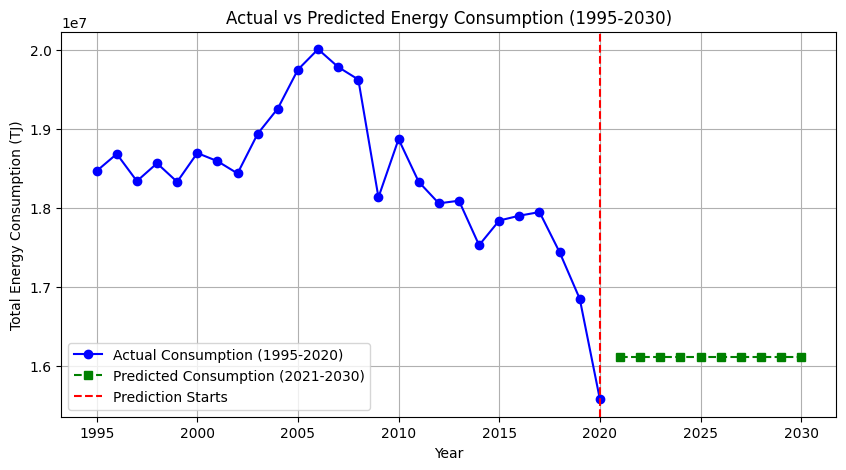

In [ ]:
# Plot actual vs predicted energy consumption
plt.figure(figsize=(10, 5))
plt.plot(df_total['Year'], df_total['Energy Consumption'], label="Actual Consumption (1995-2020)", color='blue', marker='o')
plt.plot(future_years['Year'], future_years['Predicted Consumption'], label="Predicted Consumption (2021-2030)", color='green', linestyle='dashed', marker='s')

# Highlight the prediction start year
plt.axvline(x=2020, linestyle='--', color='red', label="Prediction Starts")

# Labels and title
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (TJ)")
plt.title("Actual vs Predicted Energy Consumption (1995-2030)")
plt.legend()
plt.grid()

# Show the plot
plt.show()


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset
file_path = "https://raw.githubusercontent.com/Sajithpemarathna/Energy-consumption-prediction-data/refs/heads/main/Use%20of%20Energy%20of%20Energy%20Carriers.csv"
df = pd.read_csv(file_path)

# Preprocess Data
df.columns = df.columns.str.strip()
df_melted = df.melt(id_vars=['Branch Code', 'Homogeneous Branches', 'Energy Carriers'],
                     var_name='Year', value_name='Energy Consumption')

df_melted['Year'] = pd.to_numeric(df_melted['Year'], errors='coerce')
df_melted = df_melted.dropna(subset=['Year'])
df_melted['Year'] = df_melted['Year'].astype(int)

# Aggregate total energy consumption
df_total = df_melted.groupby('Year')['Energy Consumption'].sum().reset_index()

# Feature Engineering - Create Lag Features
for lag in range(1, 6):  # Using last 5 years as features
    df_total[f'Lag_{lag}'] = df_total['Energy Consumption'].shift(lag)

# Drop NA values
df_total.dropna(inplace=True)

# Train-Test Split (Train: 1995-2020, Predict: 2021-2030)
X = df_total.drop(columns=['Energy Consumption'])
y = df_total['Energy Consumption']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=5, shuffle=False)

# Train Model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

# Forecast for 2021-2030
future_years = pd.DataFrame({'Year': range(2021, 2031)})
for lag in range(1, 6):
    future_years[f'Lag_{lag}'] = df_total['Energy Consumption'].iloc[-lag]  # Use last known values

future_pred = xgb_model.predict(future_years.drop(columns=['Year']))

# Plot Results
plt.figure(figsize=(10, 5))
plt.plot(df_total['Year'], df_total['Energy Consumption'], label="Actual Consumption (1995-2020)", color='blue', marker='o')
plt.plot(future_years['Year'], future_pred, label="Predicted Consumption (2021-2030)", color='red', linestyle='dashed', marker='s')

plt.axvline(x=2020, linestyle='--', color='green', label="Prediction Starts")
plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (TJ)")
plt.title("Improved Forecast: Actual vs Predicted Energy Consumption (1995-2030)")
plt.legend()
plt.grid()
plt.show()


ValueError: Feature shape mismatch, expected: 6, got 5

In [ ]:
print("Training Features:", X_train.columns)
print("Forecasting Features:", future_years.columns)


Training Features: Index(['Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5'], dtype='object')
Forecasting Features: Index(['Year', 'Lag_1', 'Lag_2', 'Lag_3', 'Lag_4', 'Lag_5'], dtype='object')


In [ ]:
# Ensure all lag features are present
for lag in range(1, 6):  # Assuming 5 lag features were used
    future_years[f'Lag_{lag}'] = df_total['Energy Consumption'].iloc[-lag]  # Use last known values

# Ensure all columns match
future_years = future_years[X_train.columns]  # Select only the columns used for training

# Predict
future_pred = xgb_model.predict(future_years)


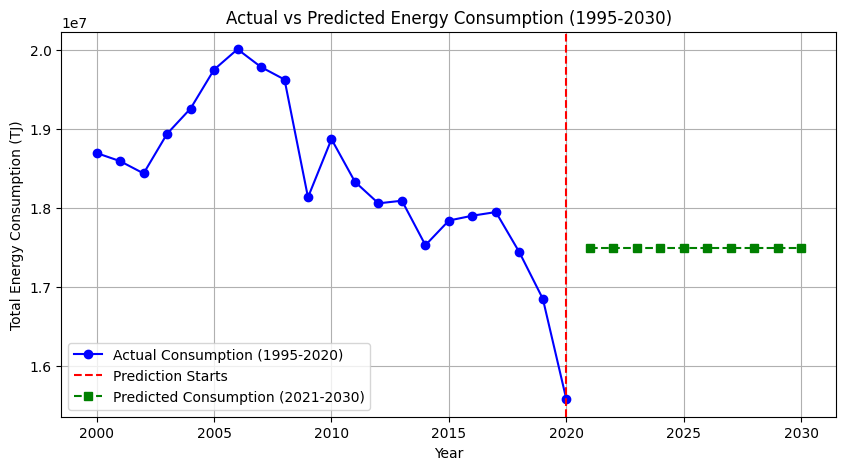

In [ ]:
# Preprocess data: Aggregate total energy consumption per year
df_total = df.iloc[:, 3:].sum()  # Sum across all branches and carriers
df_total = df_total.reset_index()
df_total.columns = ["Year", "Energy Consumption (TJ)"]
df_total["Year"] = df_total["Year"].astype(int)

# Create lag features
for lag in range(1, 6):  # Using 5 previous years as features
    df_total[f"Lag_{lag}"] = df_total["Energy Consumption (TJ)"].shift(lag)

# Drop NaN values (first 5 rows will have NaN due to lagging)
df_total = df_total.dropna()

# Split data into train-test sets
train = df_total[df_total["Year"] <= 2015]
test = df_total[df_total["Year"] > 2015]

# Define features and target
X_train = train.drop(columns=["Year", "Energy Consumption (TJ)"])
y_train = train["Energy Consumption (TJ)"]
X_test = test.drop(columns=["Year", "Energy Consumption (TJ)"])
y_test = test["Energy Consumption (TJ)"]

# Train the XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.05, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict test values
y_pred = xgb_model.predict(X_test)

# Forecast future values (2021-2030)
future_years = pd.DataFrame({"Year": np.arange(2021, 2031)})
for lag in range(1, 6):
    future_years[f"Lag_{lag}"] = df_total["Energy Consumption (TJ)"].iloc[-lag]  # Use last known values

# Predict future energy consumption
future_pred = xgb_model.predict(future_years.drop(columns=["Year"]))

# Add predictions to the dataframe
future_years["Predicted Energy Consumption (TJ)"] = future_pred

# Plot actual vs predicted values
plt.figure(figsize=(10, 5))
plt.plot(df_total["Year"], df_total["Energy Consumption (TJ)"], "bo-", label="Actual Consumption (1995-2020)")
plt.axvline(x=2020, color="r", linestyle="--", label="Prediction Starts")
plt.plot(future_years["Year"], future_years["Predicted Energy Consumption (TJ)"], "gs--", label="Predicted Consumption (2021-2030)")

plt.xlabel("Year")
plt.ylabel("Total Energy Consumption (TJ)")
plt.title("Actual vs Predicted Energy Consumption (1995-2030)")
plt.legend()
plt.grid()
plt.show()
